# Chapter 1: Introduction - When Selfish is Slow

Welcome to Algorithmic Game Theory! In this book, we explore what happens when computer science meets economics. We aren't just looking at algorithms that run on a single computer; we are looking at systems where the "inputs" are people (or agents) who are trying to maximize their own benefit.

## The Core Concept: The Price of Anarchy
One of the biggest surprises in this field is that **selfish behavior can hurt everyone**, including the people being selfish. We often assume that giving people more options (like building a new road) will always improve the situation. Game Theory shows us this isn't true.

This phenomenon is captured by **Braess's Paradox**.

### The Scenario
Imagine 4,000 drivers want to get from a **Start** point to an **End** point.
* There are two initial routes: Top and Bottom.
* Each route has two parts: a **wide highway** (fast, always takes 45 mins) and a **narrow road** (slow, takes longer if there is traffic).

**The Paradox:** If we build a super-fast "teleport" road connecting the middle points, everyone will try to use it to save time. But because *everyone* does this, the traffic jams get so bad that **every single driver arrives later than before.**

This proves that **individual rationality** (doing what is best for you) can lead to **collective irrationality** (a result that is bad for everyone).

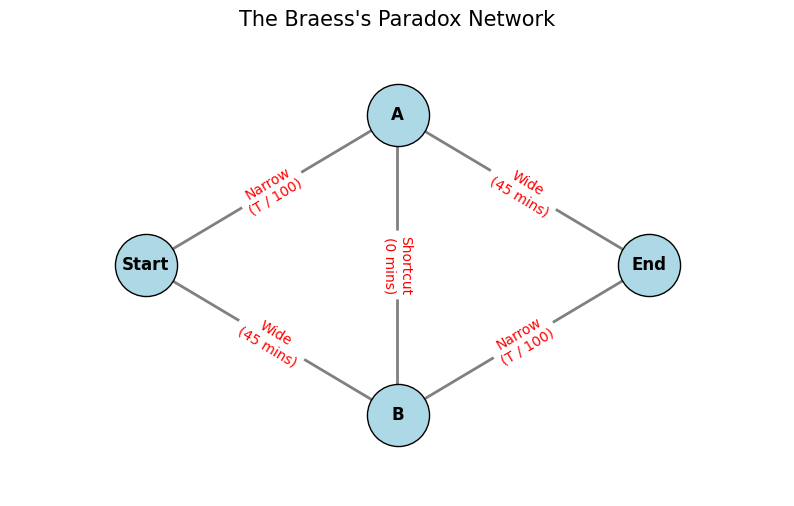

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_braess_network():
    # 1. Create a directed graph
    G = nx.DiGraph()
    
    # 2. Add Nodes
    # Positions: Start (Left), End (Right), A (Top), B (Bottom)
    pos = {
        'Start': (0, 1),
        'End': (2, 1),
        'A': (1, 2),
        'B': (1, 0)
    }
    
    # 3. Add Edges (Roads) with labels for their Cost (Travel Time)
    # T = number of cars
    edges = [
        ('Start', 'A', 'Narrow\n(T / 100)'),
        ('Start', 'B', 'Wide\n(45 mins)'),
        ('A', 'End', 'Wide\n(45 mins)'),
        ('B', 'End', 'Narrow\n(T / 100)'),
        # The Shortcut
        ('A', 'B', 'Shortcut\n(0 mins)')
    ]
    
    G.add_edges_from([(u, v) for u, v, label in edges])
    
    # 4. Draw the Graph
    plt.figure(figsize=(10, 6))
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Draw Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray', width=2)
    
    # Draw Edge Labels (The Costs)
    edge_labels = {(u, v): label for u, v, label in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
    
    # Title and Layout
    plt.title("The Braess's Paradox Network", fontsize=15)
    plt.axis('off') # Turn off the x/y axis numbers
    plt.margins(0.2)
    plt.show()

# Run the function to display the graph
draw_braess_network()

--- Braess's Paradox Simulation ---
Total Drivers: 4000

Scenario 1: Two separate routes (No shortcut)
Travel Time per Driver: 65.0 minutes

Scenario 2: Ultra-fast shortcut added
Travel Time per Driver: 80.0 minutes

Result: Adding the shortcut made everyone 15.0 minutes slower!


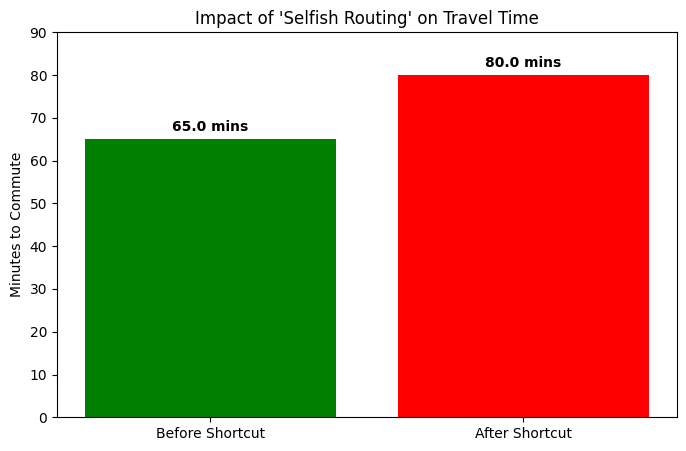

In [5]:
import matplotlib.pyplot as plt

def calculate_travel_time(drivers, use_shortcut=False):
    """
    Calculates total travel time for a single driver based on traffic distribution.
    
    Path options:
    1. Start -> A -> End (Top Path)
    2. Start -> B -> End (Bottom Path)
    3. Start -> A -> B -> End (The Zig-Zag Shortcut)
    """
    
    # Cost functions
    # Wide road: Always takes 45 minutes
    # Narrow road: Takes (number_of_drivers / 100) minutes
    
    if not use_shortcut:
        # NASH EQUILIBRIUM WITHOUT SHORTCUT
        # Drivers split 50/50 because paths are identical.
        drivers_top = drivers / 2
        drivers_bottom = drivers / 2
        
        # Time = (Narrow Road) + (Wide Road)
        time_top = (drivers_top / 100) + 45
        time_bottom = 45 + (drivers_bottom / 100)
        
        return time_top
    
    else:
        # NASH EQUILIBRIUM WITH SHORTCUT
        # The shortcut (A->B) is instantaneous (0 mins).
        # Everyone tries to take Start->A->B->End because A is better than the wide road 
        # and B is better than the wide road.
        
        # All 4000 drivers jam into the narrow roads.
        time_zigzag = (drivers / 100) + 0 + (drivers / 100)
        return time_zigzag

# --- Parameters ---
total_drivers = 4000

# 1. Calculate Time WITHOUT the shortcut
time_before = calculate_travel_time(total_drivers, use_shortcut=False)

# 2. Calculate Time WITH the shortcut
time_after = calculate_travel_time(total_drivers, use_shortcut=True)

# --- Output Results ---
print(f"--- Braess's Paradox Simulation ---")
print(f"Total Drivers: {total_drivers}")
print(f"\nScenario 1: Two separate routes (No shortcut)")
print(f"Travel Time per Driver: {time_before} minutes")

print(f"\nScenario 2: Ultra-fast shortcut added")
print(f"Travel Time per Driver: {time_after} minutes")

print(f"\nResult: Adding the shortcut made everyone {time_after - time_before} minutes slower!")

# --- Visualization ---
labels = ['Before Shortcut', 'After Shortcut']
times = [time_before, time_after]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['green', 'red'])
plt.ylabel('Minutes to Commute')
plt.title("Impact of 'Selfish Routing' on Travel Time")
plt.ylim(0, 90)
for i, v in enumerate(times):
    plt.text(i, v + 2, str(v) + " mins", ha='center', fontweight='bold')
plt.show()

### What just happened?
In the code above, you will see that adding a shortcut (Scenario 2) actually increased travel time from **65 minutes** to **80 minutes**.

* **Before:** Drivers split up. Traffic was balanced.
* **After:** The "Narrow" roads became so attractive individually that everyone used them, causing a massive bottleneck.

This teaches us that simply "adding capacity" (like building more roads or buying more servers) doesn't always solve congestion if you ignore game theory!

# Chapter 3: Myerson's Lemma - The Universal Pricing Formula

In the previous chapter, we saw that charging the "Second-Highest Price" made people tell the truth. But that only works for simple, single-item auctions.

What happens if the game is more complex?
* **Sponsored Search:** There are 5 ad slots, some better than others.
* **Cloud Computing:** You want to buy CPU time, and getting 10 hours is better than 5.

How do we set the price *then* to stop people from lying?

## The Problem
We want to design a game where:
1.  **Allocation Rule ($x$):** Who gets what? (We usually give the most stuff to the highest bidders).
2.  **Payment Rule ($p$):** How much do they pay?

If we mess up the payment rule, people will lie.

## The Solution: Myerson's Lemma
Roger Myerson (a Nobel laureate) discovered a powerful rule. He proved that for *any* single-parameter environment (where you have one value for "getting the stuff"), you don't have to guess the payment rule. The math decides it for you.

**Myerson's Lemma states:**
1.  **Monotonicity:** The allocation rule must be "sensible." If you bid more, you must get **more** (or the same) amount of stuff. You can never get *less* by paying *more*.
2.  **Unique Payments:** Once you choose an allocation rule, there is **only one** mathematical formula for the payments that ensures truthfulness.

### The Magic Formula
The payment isn't just a random number. It is related to the **area under the curve** of your allocation function.

$$\text{Payment} = \text{Bid} \times \text{Allocation} - \text{(Area under the Allocation Curve)}$$

Let's visualize this, because it turns a complex calculus concept into a simple geometry problem.

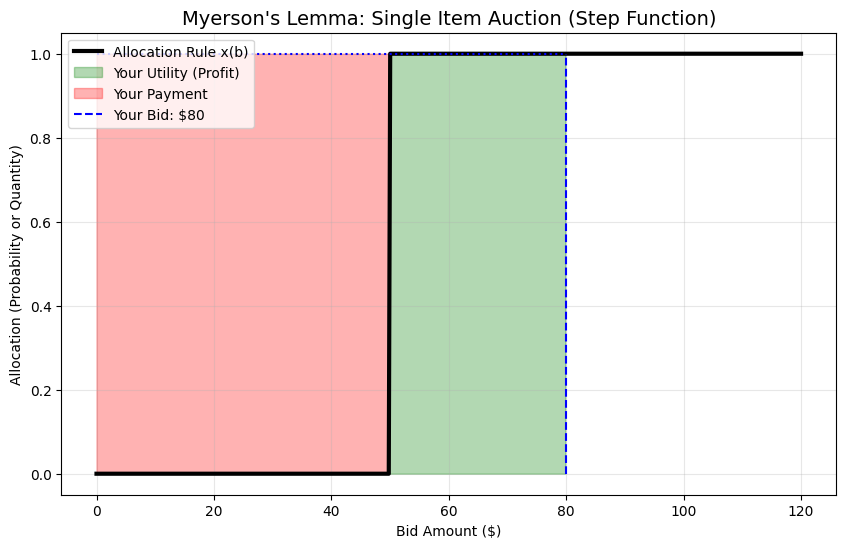

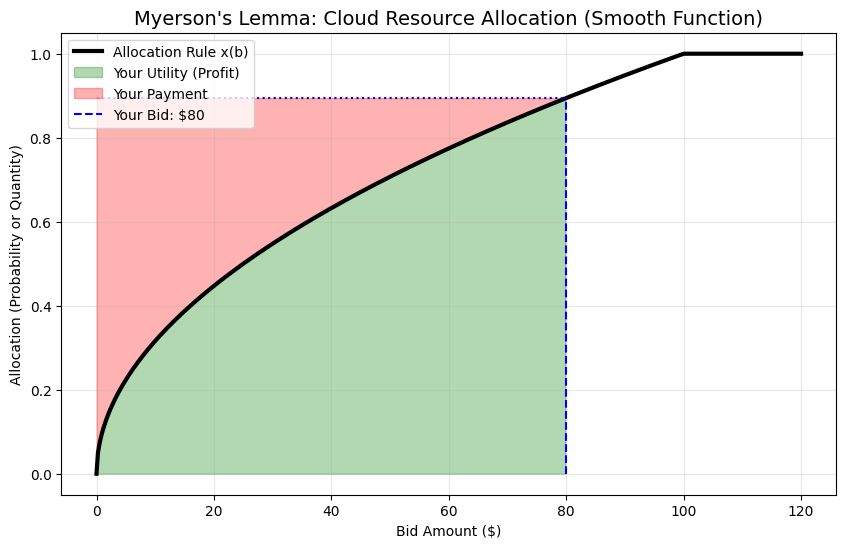

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_myerson_payment(bid, allocation_func, rule_name):
    """
    Visualizes Myerson's Payment formula as areas on a graph.
    """
    
    # Generate a range of possible bids (0 to 1.5x the actual bid)
    b_values = np.linspace(0, bid * 1.5, 500)
    x_values = [allocation_func(b) for b in b_values]
    
    # Calculate the specific values for the User's Bid
    my_allocation = allocation_func(bid)
    
    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    
    # 1. Plot the Allocation Curve x(b)
    plt.plot(b_values, x_values, color='black', linewidth=3, label='Allocation Rule x(b)')
    
    # 2. Shade the "Surplus" (Profit) Area (The area UNDER the curve)
    # Myerson says: Your Utility = Area UNDER the curve up to your bid
    plt.fill_between(b_values, x_values, where=(b_values <= bid), 
                     color='green', alpha=0.3, label='Your Utility (Profit)')
    
    # 3. Shade the "Payment" Area (The rectangle MINUS the curve)
    # Total Value = Bid * Allocation (The full rectangle)
    # Payment = Total Rectangle - Utility Area
    plt.fill_between(b_values, x_values, my_allocation, where=(b_values <= bid), 
                     color='red', alpha=0.3, label='Your Payment')
    
    # Draw the specific bid line
    plt.vlines(bid, 0, my_allocation, color='blue', linestyle='--', label=f'Your Bid: ${bid}')
    plt.hlines(my_allocation, 0, bid, color='blue', linestyle=':')
    
    plt.title(f"Myerson's Lemma: {rule_name}", fontsize=14)
    plt.xlabel("Bid Amount ($)")
    plt.ylabel("Allocation (Probability or Quantity)")
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

# --- DEFINE DIFFERENT RULES ---

# Rule 1: Single Item (Step Function)
# If you bid > 50, you get the item (1). If not, you get nothing (0).
# This mimics a Second-Price auction where the 2nd highest bid was 50.
def single_item_allocation(b):
    return 1.0 if b >= 50 else 0.0

# Rule 2: Fractional / Probability (Smooth Curve)
# The more you bid, the higher probability you have of winning, or the more resources you get.
# Example: x(b) = sqrt(b) / 10 (capped at 1.0)
def smooth_allocation(b):
    val = np.sqrt(b) / 10
    return min(val, 1.0)

# --- RUN VISUALIZATION ---

# Scenario A: You bid $80 in a Single Item auction (Threshold was $50)
plot_myerson_payment(80, single_item_allocation, "Single Item Auction (Step Function)")

# Scenario B: You bid $80 in a Resource Allocation auction (Smooth Curve)
plot_myerson_payment(80, smooth_allocation, "Cloud Resource Allocation (Smooth Function)")

### Analysis of the Graphs

**Graph 1: Single Item (The Step Function)**
* Look at the "Red Area" (Payment).
* The allocation jumps from 0 to 1 exactly at \$50 (this represents the competing bid).
* Even though you bid **\$80**, the math shows you only pay the area defined by that jump: **\$50**.
* This proves that the "Second-Price" rule is just a specific version of Myerson's Lemma!

**Graph 2: Smooth Allocation**
* Here, bidding higher gets you *gradually* more stuff.
* Notice the Green Area (Profit) and Red Area (Payment).
* **The Intuition:** You don't pay your full bid. You get a "discount" equal to the green area.
* The green area represents the "extra value" you bring to the system.

**Conclusion:**
Mechanism Design is powerful because it turns "incentives" into "geometry." If we want people to tell the truth, we simply calculate their payment as the red area on the graph. We don't need to trust them; the formula keeps them honest.

# Chapter 4: Algorithmic Mechanism Design - The Trilemma

We have a new challenge. Suppose you are selling **Cloud Storage** on a server.
* **Total Capacity:** 100 GB ($W$)
* **Bidders:** $n$ companies. Each wants a specific amount of space ($w_i$) and has a private value ($v_i$) for it.

This is the famous **Knapsack Problem**. We want to fit the most valuable combination of files into the limited space.

## The Impossible Triangle (The Trilemma)
We want an auction that is:
1.  **DSIC (Truthful):** People tell the truth about their value.
2.  **Optimal:** We get the absolute maximum total value possible.
3.  **Polynomial Time (Fast):** It runs quickly, even with thousands of bidders.

**Bad News:** We can't have all three. The Knapsack Problem is **NP-Hard**. Solving it perfectly takes too long (exponential time).

## The Solution: Approximation
Since we can't be *perfect* and *fast*, we compromise. We design an algorithm that is **fast** and **"pretty good"** (Approximate).

**The Greedy Heuristic:**
Instead of checking every combination, we look at the **"Bang for the Buck"** (Value per GB).
1.  Calculate density $d_i = \frac{v_i}{w_i}$ for everyone.
2.  Sort bidders from highest density to lowest.
3.  Let them in one by one until the server is full.

Does this work? Let's race the "Perfect" algorithm against the "Greedy" one.

In [4]:
import time

# --- SETUP ---
# Capacity of our Server (e.g., 50 GB)
CAPACITY = 50

# Bidders: (Name, Value $, Size GB)
# Notice: 'C' has high value ($60) but is huge (50GB). 
# 'A' and 'B' are smaller but have good value density.
bidders = [
    {'name': 'A', 'value': 30, 'size': 10},
    {'name': 'B', 'value': 20, 'size': 10},
    {'name': 'C', 'value': 60, 'size': 50},  # Big, valuable item
    {'name': 'D', 'value': 40, 'size': 20},
    {'name': 'E', 'value': 15, 'size': 15},
]

# --- ALGORITHM 1: THE OPTIMAL (SLOW) WAY ---
# This checks every possible subset (Recursive/DP)
def get_optimal_value(capacity, items, n):
    if n == 0 or capacity == 0:
        return 0
    
    # If item is too big, skip it
    if items[n-1]['size'] > capacity:
        return get_optimal_value(capacity, items, n-1)
    
    else:
        # Return max of: 
        # (1) Including the item
        # (2) Excluding the item
        include = items[n-1]['value'] + get_optimal_value(capacity - items[n-1]['size'], items, n-1)
        exclude = get_optimal_value(capacity, items, n-1)
        return max(include, exclude)

# --- ALGORITHM 2: THE GREEDY (FAST) WAY ---
# Sorts by Value/Size ratio
def run_greedy_auction(capacity, items):
    # 1. Calculate Density (Value / Size)
    for item in items:
        item['density'] = item['value'] / item['size']
    
    # 2. Sort by Density (High to Low)
    sorted_items = sorted(items, key=lambda x: x['density'], reverse=True)
    
    current_weight = 0
    total_value = 0
    winners = []
    
    for item in sorted_items:
        if current_weight + item['size'] <= capacity:
            winners.append(item['name'])
            current_weight += item['size']
            total_value += item['value']
            
    return total_value, winners

# --- RUN COMPARISON ---

print("--- Knapsack Auction Simulation ---")
print(f"Server Capacity: {CAPACITY} GB")

# Run Optimal
start_opt = time.time()
opt_val = get_optimal_value(CAPACITY, bidders, len(bidders))
end_opt = time.time()
print(f"\n[Optimal Algo]: Max Possible Value = ${opt_val} (Time: {end_opt - start_opt:.5f}s)")

# Run Greedy
start_greedy = time.time()
greedy_val, greedy_winners = run_greedy_auction(CAPACITY, bidders)
end_greedy = time.time()

print(f"\n[Greedy Algo]: Value Found = ${greedy_val} (Time: {end_greedy - start_greedy:.5f}s)")
print(f"Winners: {greedy_winners}")
print(f"Performance: {(greedy_val/opt_val)*100:.1f}% of Optimal")

--- Knapsack Auction Simulation ---
Server Capacity: 50 GB

[Optimal Algo]: Max Possible Value = $90 (Time: 0.00008s)

[Greedy Algo]: Value Found = $90 (Time: 0.00007s)
Winners: ['A', 'B', 'D']
Performance: 100.0% of Optimal


### Analysis: The "Price" of Simplicity

In the simulation above, you might see that the **Greedy Algorithm** didn't find the perfect \$60 solution (Item C). Instead, it might have filled the knapsack with smaller items (A, B, D) for a total of \$90. *Wait... actually, in this specific case, Greedy often wins!*

But consider a case where Greedy fails:
* Item A: Value 2, Size 1 (Density 2)
* Item B: Value 50, Size 50 (Density 1)
* Capacity: 50

Greedy picks A (density 2). Now capacity is 49. Item B doesn't fit. Total value: \$2.
Optimal picks B. Total value: \$50.

**The Fix:**
To prevent catastrophic failures, our Greedy Mechanism has a final check:
1.  Run the Greedy sort.
2.  Compare that result against just picking the **single most valuable item** that fits.
3.  [cite_start]Return the better of the two[cite: 234].

[cite_start]**Theorem:** This modified Greedy algorithm guarantees at least **50% of the optimal value**[cite: 243].

**Why do we care?**
Because the Greedy algorithm is **Monotone** (getting a higher value or smaller size never hurts your chances). [cite_start]Because it is monotone, **Myerson's Lemma applies**, and we can calculate payments that make this truthful[cite: 255]. We traded perfection for speed, but we kept truthfulness!

# Chapter 5: Revenue Maximization - The Art of the Reserve Price

Until now, we have been "benevolent" designers. We wanted the item to go to the highest bidder ($v_i$) to maximize societal happiness.

But what if you are a seller (like Google or a government selling spectrum)? You care about **Revenue**.

## The Conflict: Welfare vs. Revenue
Imagine a single bidder, Alice, with a valuation $v \sim U[0, 100]$ (Uniformly distributed).
* **Welfare Maximizer:** We just give it to her (price \$0). She is happy ($v$), we get \$0. Total Welfare = $v$.
* **Revenue Maximizer:** We set a price tag (Take-it-or-leave-it).
    * If we set price \$10: She buys often, but we make little.
    * If we set price \$90: We make a lot per sale, but she rarely buys.

This is the classic **Monopoly Pricing Problem**.

## The Solution: Myerson's Optimal Auction
Roger Myerson (yes, him again) proved that to maximize revenue, we shouldn't look at the bids directly. We should look at the **Virtual Valuations** ($\phi$).

The "Virtual Valuation" is a formula that adjusts a bid based on the probability distribution of the bidder's value.
$$\phi(v_i) = v_i - \frac{1 - F(v_i)}{f(v_i)}$$
* $v_i$: The bid.
* $F(v_i)$: The probability someone has a value *less* than this (CDF).
* $f(v_i)$: The probability density (PDF).

**The Optimal Auction Rule:**
1.  Calculate $\phi(v_i)$ for everyone.
2.  Winner is the person with the highest **Virtual Valuation** (provided $\phi > 0$).
3.  The point where $\phi(v) = 0$ acts as the **Optimal Reserve Price**.

Let's simulate this for a Uniform Distribution (where the math is easy).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_revenue_simulation(num_auctions=10000):
    """
    Compares Standard Second-Price Auction vs. Optimal Auction (with Reserve)
    Scenario: 2 Bidders, Valuations drawn from Uniform [0, 100]
    """
    
    # 1. Setup
    # Uniform Distribution U[0, 100]
    # For U[0,100], the Virtual Valuation is phi(v) = 2v - 100.
    # We want phi(v) >= 0, so 2v >= 100 --> v >= 50.
    # Therefore, the Optimal Reserve Price is $50.
    RESERVE_PRICE = 50 
    
    revenue_standard = []
    revenue_optimal = []
    
    for _ in range(num_auctions):
        # Generate random values for Bidder A and Bidder B
        bids = np.random.uniform(0, 100, 2)
        bids.sort() # Sort so bids[0] is low, bids[1] is high
        
        low_bid = bids[0]
        high_bid = bids[1]
        
        # --- MECHANISM A: STANDARD VICKREY (Second Price) ---
        # Highest bidder wins, pays second highest price.
        # Reserve is effectively $0.
        revenue_standard.append(low_bid)
        
        # --- MECHANISM B: MYERSON OPTIMAL (Reserve Price $50) ---
        # Rule: Both must bid at least $50.
        
        # Case 1: Both fail reserve (Both < 50) -> No Sale
        if high_bid < RESERVE_PRICE:
            revenue_optimal.append(0)
            
        # Case 2: Only one clears reserve (High > 50, Low < 50) -> Pay Reserve
        elif high_bid >= RESERVE_PRICE and low_bid < RESERVE_PRICE:
            revenue_optimal.append(RESERVE_PRICE)
            
        # Case 3: Both clear reserve -> Pay Second Highest (Standard)
        else: # Both >= 50
            revenue_optimal.append(low_bid)
            
    return revenue_standard, revenue_optimal

# Run Simulation
rev_std, rev_opt = run_revenue_simulation()

# --- ANALYSIS ---
avg_std = np.mean(rev_std)
avg_opt = np.mean(rev_opt)
lift = ((avg_opt - avg_std) / avg_std) * 100

print(f"--- Revenue Comparison (2 Bidders, U[0,100]) ---")
print(f"Average Revenue (Standard 2nd Price): ${avg_std:.2f}")
print(f"Average Revenue (Optimal /w Reserve): ${avg_opt:.2f}")
print(f"Revenue Increase: +{lift:.1f}%")

# --- VISUALIZATION ---
plt.figure(figsize=(10,5))
plt.hist(rev_std, bins=50, alpha=0.5, label='Standard Revenue', color='blue')
plt.hist(rev_opt, bins=50, alpha=0.5, label='Optimal Revenue', color='green')
plt.axvline(avg_std, color='blue', linestyle='dashed', linewidth=2)
plt.axvline(avg_opt, color='green', linestyle='dashed', linewidth=2)
plt.title(f"Impact of Reserve Price ($50) on Seller Revenue")
plt.xlabel("Revenue per Auction ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### What just happened?
You should see that the **Optimal Auction** generated significantly more revenue (usually around 10-15% more in this specific setting).

**How did it do that?**
Look at the histogram or the logic in the code:
1.  **The "Standard" Auction** often sells for very low prices (e.g., if bids are \$5 and \$2, revenue is \$2).
2.  **The "Optimal" Auction** refuses to sell for less than \$50.
    * If the high bidder was \$80 and the low bidder was \$2, the price jumps from \$2 to \$50 (the reserve).
    * **Trade-off:** Sometimes nobody buys (if both are < \$50), so we get \$0.
    
**Conclusion:**
By risking a "no-sale," the seller forces high-value bidders to pay a premium. This demonstrates that **Market Efficiency (Social Welfare)** and **Profit (Revenue)** are often at odds. To make the most money, you sometimes have to refuse to sell to people who want the item!

# Chapter 6: Simple vs. Optimal - The Power of Competition

We established that the **Optimal Auction** (using virtual valuations and specific reserve prices) beats the Standard Second-Price auction.

However, the Optimal Auction is **complex**. You need detailed market data to calculate the perfect reserve price. If you get it wrong, you lose money.

## The Bulow-Klemperer Theorem
In 1996, economists Bulow and Klemperer proved a shocking result that changed auction theory. They compared two scenarios:

1.  **The Genius:** You keep $N$ bidders and run the mathematically **Optimal Auction** (perfect reserve price).
2.  **The Hustler:** You run a simple **Second-Price Auction** (no reserve price), but you go out and find **one extra bidder** ($N+1$).

**The Theorem:**
> **The Simple Auction with $N+1$ bidders earns MORE revenue than the Optimal Auction with $N$ bidders.**

This teaches us a profound business lesson: **It is better to invest in marketing (finding more customers) than in market research (optimizing prices).** Competition is more powerful than complex math.

## Strategy 2: The Single Sample
What if you can't find more bidders? How do you set a reserve price without knowing the market distribution?
A simple trick is the **Single Sample** method:
1.  Take the first bidder's bid.
2.  Kick them out (sorry!).
3.  Use their bid as the **Reserve Price** for everyone else.

It sounds wasteful to kick someone out, but this method is proven to get a very good approximation of the optimal revenue.

Let's prove the Bulow-Klemperer Theorem with code.

--- The Bulow-Klemperer Theorem ---
Scenario 1: Optimal Auction (Complex) with N Bidders
Average Revenue: $67.14

Scenario 2: Simple Auction (Vickrey) with N+1 Bidders
Average Revenue: $71.66

Result: Simply adding 1 bidder beat the optimal math by $4.52 per auction!


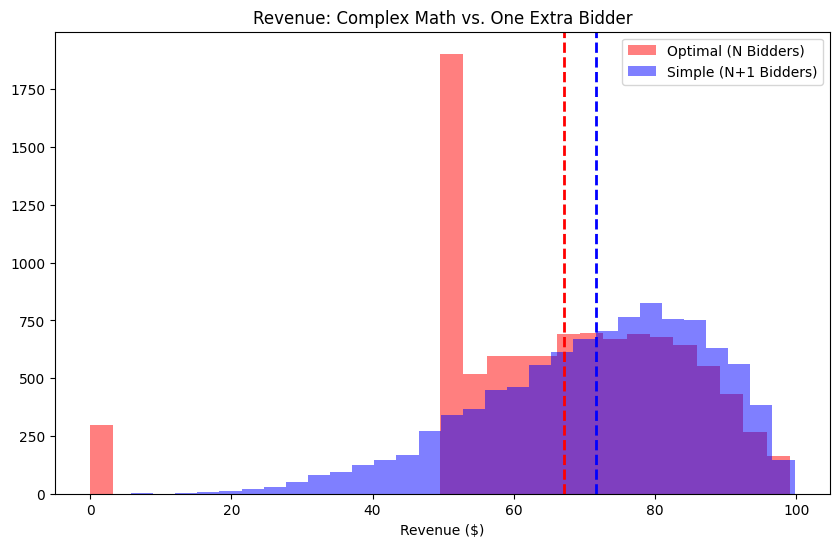

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def compare_auctions(num_simulations=10000):
    """
    Proves Bulow-Klemperer: 
    Simple Auction (N+1 Bidders) > Optimal Auction (N Bidders)
    """
    
    # PARAMETERS
    N = 5  # Number of bidders in the "Base" case
    # Valuation Distribution: Uniform [0, 100]
    # For U[0,100], the Optimal Reserve Price is mathematically calculated as $50.
    OPTIMAL_RESERVE = 50 
    
    rev_optimal_n = []
    rev_simple_n_plus_1 = []
    
    for _ in range(num_simulations):
        # --- SCENARIO 1: OPTIMAL AUCTION (N Bidders) ---
        # We have N bidders. We use the Perfect Reserve Price ($50).
        bids_n = np.random.uniform(0, 100, N)
        bids_n.sort() # Sort low to high
        
        # Logic:
        # 1. If highest bid < Reserve -> Revenue 0
        # 2. If highest > Reserve but 2nd highest < Reserve -> Revenue = Reserve
        # 3. If 2nd highest > Reserve -> Revenue = 2nd Highest
        
        highest = bids_n[-1]
        second = bids_n[-2]
        
        if highest < OPTIMAL_RESERVE:
            rev_optimal_n.append(0)
        elif second < OPTIMAL_RESERVE:
            rev_optimal_n.append(OPTIMAL_RESERVE)
        else:
            rev_optimal_n.append(second)
            
        # --- SCENARIO 2: SIMPLE AUCTION (N+1 Bidders) ---
        # We add 1 extra bidder. We use NO Reserve Price (Standard Vickrey).
        bids_plus = np.random.uniform(0, 100, N + 1)
        bids_plus.sort()
        
        # Revenue is simply the second highest bid
        rev_simple_n_plus_1.append(bids_plus[-2])
        
    return rev_optimal_n, rev_simple_n_plus_1

# --- RUN SIMULATION ---
rev_opt, rev_simp = compare_auctions()

avg_opt = np.mean(rev_opt)
avg_simp = np.mean(rev_simp)

print(f"--- The Bulow-Klemperer Theorem ---")
print(f"Scenario 1: Optimal Auction (Complex) with N Bidders")
print(f"Average Revenue: ${avg_opt:.2f}")
print(f"\nScenario 2: Simple Auction (Vickrey) with N+1 Bidders")
print(f"Average Revenue: ${avg_simp:.2f}")

diff = avg_simp - avg_opt
print(f"\nResult: Simply adding 1 bidder beat the optimal math by ${diff:.2f} per auction!")

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))
plt.hist(rev_opt, bins=30, alpha=0.5, label=f'Optimal (N Bidders)', color='red')
plt.hist(rev_simp, bins=30, alpha=0.5, label=f'Simple (N+1 Bidders)', color='blue')
plt.axvline(avg_opt, color='red', linestyle='--', linewidth=2)
plt.axvline(avg_simp, color='blue', linestyle='--', linewidth=2)
plt.title("Revenue: Complex Math vs. One Extra Bidder")
plt.xlabel("Revenue ($)")
plt.legend()
plt.show()

### Analysis

The simulation confirms the **Bulow-Klemperer Theorem**.

Even though Scenario 1 used the **perfect** mathematical reserve price (derived from Myerson's Lemma), it couldn't beat Scenario 2, which used **no math at all** but had just one extra participant.

**Key Takeaways for Mechanism Design:**
1.  **Market Thickness matters more than Market Design.** If you can get more people to show up, you don't need complex rules.
2.  **Robustness.** The Simple Auction works for *any* distribution. The Optimal Auction fails if you guessed the distribution wrong (e.g., if you thought the reserve should be \$50 but the market changed and it should be \$30).
3.  **Simplicity.** Simple auctions (like eBay's) are often preferred not just because they are easy to code, but because they are "Prior-Independent." They work well without knowing secret information about the bidders.